# Tutorial: Minimum Eigen Optimizer

For original tutorial refer to https://qiskit-community.github.io/qiskit-optimization/tutorials/03_minimum_eigen_optimizer.html#

In [ ]:
! pip install qiskit_optimization

In [8]:
from typing import List, Tuple

import numpy as np

from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.visualization import plot_histogram
from qiskit_optimization.algorithms import (
    MinimumEigenOptimizer,
    RecursiveMinimumEigenOptimizer,
    SolutionSample,
    OptimizationResultStatus,
)
from qiskit_optimization import QuadraticProgram

from qiskit_braket_provider import AWSBraketProvider

### Converting a QUBO to an Operator

In [5]:
# create a QUBO
qubo = QuadraticProgram()
qubo.binary_var("x")
qubo.binary_var("y")
qubo.binary_var("z")
qubo.minimize(
    linear=[1, -2, 3], quadratic={("x", "y"): 1, ("x", "z"): -1, ("y", "z"): 2}
)
print(qubo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: x - 2 y + 3 z + [ 2 x*y - 2 x*z + 4 y*z ]/2
Subject To

Bounds
 0 <= x <= 1
 0 <= y <= 1
 0 <= z <= 1

Binaries
 x y z
End



In [6]:
op, offset = qubo.to_ising()
print(f"offset: {offset}")
print("operator:")
print(op)

offset: 1.5
operator:
-1.75 * ZII
+ 0.25 * IZI
+ 0.5 * ZZI
- 0.5 * IIZ
- 0.25 * ZIZ
+ 0.25 * IZZ


In [7]:
qp = QuadraticProgram()
qp.from_ising(op, offset, linear=True)
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: x0 - 2 x1 + 3 x2 + [ 2 x0*x1 - 2 x0*x2 + 4 x1*x2 ]/2
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1

Binaries
 x0 x1 x2
End



### Solving a QUBO with the MinimumEigenOptimizer


In [13]:
algorithm_globals.random_seed = 10598

quantum_instance = QuantumInstance(
    AWSBraketProvider().backends(local=True)[0],
    seed_simulator=algorithm_globals.random_seed,
    seed_transpiler=algorithm_globals.random_seed,
)
qaoa_mes = QAOA(quantum_instance=quantum_instance, initial_point=[0.0, 0.0])
exact_mes = NumPyMinimumEigensolver()

In [14]:
qaoa = MinimumEigenOptimizer(qaoa_mes)  # using QAOA
exact = MinimumEigenOptimizer(
    exact_mes
)  # using the exact classical numpy minimum eigen solver

In [15]:
exact_result = exact.solve(qubo)
print(exact_result)

optimal function value: -2.0
optimal value: [0. 1. 0.]
status: SUCCESS


In [16]:
qaoa_result = qaoa.solve(qubo)
print(qaoa_result)

optimal function value: -2.0
optimal value: [0. 1. 0.]
status: SUCCESS


### Analysis of Samples

In [17]:
print("variable order:", [var.name for var in qaoa_result.variables])
for smpl in qaoa_result.samples:
    print(smpl)

variable order: ['x', 'y', 'z']
SolutionSample(x=array([0., 1., 0.]), fval=-2.0, probability=0.07031249999999999, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 0.]), fval=0.0, probability=0.0625, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 0.]), fval=0.0, probability=0.08496093750000001, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 0.]), fval=1.0, probability=0.08007812500000001, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 1.]), fval=3.0, probability=0.1611328125, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 1.]), fval=3.0, probability=0.20800781249999997, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 1., 1.]), fval=3.0, probability=0.16015625, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 1.]), fval=4.0, probability=0.1728515625, status=<OptimizationResultStatus.

In [18]:
def get_filtered_samples(
    samples: List[SolutionSample],
    threshold: float = 0,
    allowed_status: Tuple[OptimizationResultStatus] = (
        OptimizationResultStatus.SUCCESS,
    ),
):
    """Returns filtered samples."""
    res = []
    for sample in samples:
        if sample.status in allowed_status and sample.probability > threshold:
            res.append(sample)

    return res

In [19]:
filtered_samples = get_filtered_samples(
    qaoa_result.samples,
    threshold=0.005,
    allowed_status=(OptimizationResultStatus.SUCCESS,),
)
for s in filtered_samples:
    print(s)

SolutionSample(x=array([0., 1., 0.]), fval=-2.0, probability=0.07031249999999999, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 0.]), fval=0.0, probability=0.0625, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 0.]), fval=0.0, probability=0.08496093750000001, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 0.]), fval=1.0, probability=0.08007812500000001, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 0., 1.]), fval=3.0, probability=0.1611328125, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 0., 1.]), fval=3.0, probability=0.20800781249999997, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([0., 1., 1.]), fval=3.0, probability=0.16015625, status=<OptimizationResultStatus.SUCCESS: 0>)
SolutionSample(x=array([1., 1., 1.]), fval=4.0, probability=0.1728515625, status=<OptimizationResultStatus.SUCCESS: 0>)


In [20]:
fvals = [s.fval for s in qaoa_result.samples]
probabilities = [s.probability for s in qaoa_result.samples]

In [21]:
np.mean(fvals)

1.5

In [22]:
np.std(fvals)

1.9364916731037085

In [23]:
samples_for_plot = {
    " ".join(
        f"{qaoa_result.variables[i].name}={int(v)}" for i, v in enumerate(smpl.x)
    ): smpl.probability
    for smpl in filtered_samples
}
samples_for_plot

{'x=0 y=1 z=0': 0.07031249999999999,
 'x=0 y=0 z=0': 0.0625,
 'x=1 y=1 z=0': 0.08496093750000001,
 'x=1 y=0 z=0': 0.08007812500000001,
 'x=0 y=0 z=1': 0.1611328125,
 'x=1 y=0 z=1': 0.20800781249999997,
 'x=0 y=1 z=1': 0.16015625,
 'x=1 y=1 z=1': 0.1728515625}

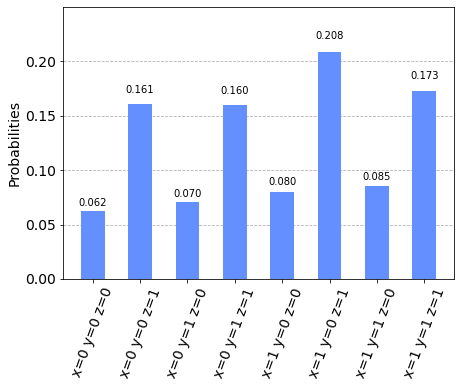

In [24]:
plot_histogram(samples_for_plot)

### RecursiveMinimumEigenOptimizer

In [25]:
rqaoa = RecursiveMinimumEigenOptimizer(
    qaoa, min_num_vars=1, min_num_vars_optimizer=exact
)

In [26]:
rqaoa_result = rqaoa.solve(qubo)
print(rqaoa_result)

optimal function value: -2.0
optimal value: [0. 1. 0.]
status: SUCCESS


In [27]:
filtered_samples = get_filtered_samples(
    rqaoa_result.samples,
    threshold=0.005,
    allowed_status=(OptimizationResultStatus.SUCCESS,),
)

In [28]:
samples_for_plot = {
    " ".join(
        f"{rqaoa_result.variables[i].name}={int(v)}" for i, v in enumerate(s.x)
    ): s.probability
    for s in filtered_samples
}
samples_for_plot

{'x=0 y=1 z=0': 1.0}

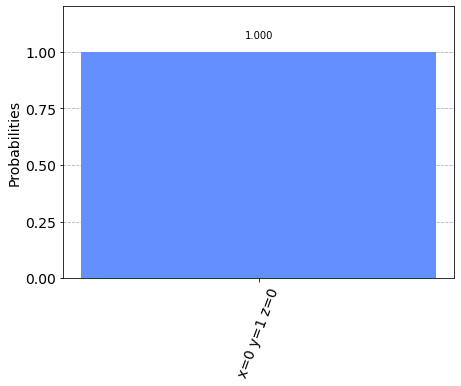

In [29]:
plot_histogram(samples_for_plot)